<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ala5-BioEn-optimize-API-example" data-toc-modified-id="Ala5-BioEn-optimize-API-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ala5 BioEn-optimize API example</a></span></li><li><span><a href="#Read-$\phi$-and-$\psi$-dihedral-angles" data-toc-modified-id="Read-$\phi$-and-$\psi$-dihedral-angles-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read $\phi$ and $\psi$ dihedral angles</a></span></li><li><span><a href="#example-calculation-for-J-couplings" data-toc-modified-id="example-calculation-for-J-couplings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>example calculation for J-couplings</a></span></li><li><span><a href="#Read-J-couplings" data-toc-modified-id="Read-J-couplings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Read J-couplings</a></span></li><li><span><a href="#Prepare-BioEn-optimization" data-toc-modified-id="Prepare-BioEn-optimization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prepare BioEn optimization</a></span><ul class="toc-item"><li><span><a href="#Function-to-run-series-of-BioEn-optimizations" data-toc-modified-id="Function-to-run-series-of-BioEn-optimizations-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Function to run series of BioEn optimizations</a></span></li><li><span><a href="#Handling-output" data-toc-modified-id="Handling-output-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Handling output</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Elbow-plots" data-toc-modified-id="Elbow-plots-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Elbow plots</a></span></li><li><span><a href="#Ramachandran-plots" data-toc-modified-id="Ramachandran-plots-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Ramachandran plots</a></span><ul class="toc-item"><li><span><a href="#MD-results" data-toc-modified-id="MD-results-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>MD results</a></span></li><li><span><a href="#Optimal-BioEn-ensemble" data-toc-modified-id="Optimal-BioEn-ensemble-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Optimal BioEn ensemble</a></span></li></ul></li><li><span><a href="#PDB-statistics" data-toc-modified-id="PDB-statistics-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>PDB statistics</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Plot</a></span></li></ul></li></ul></div>

In [282]:
import sys
sys.version

'3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 23:01:00) \n[GCC 7.3.0]'

### Ala5 BioEn-optimize API example

Some code to generate the BioEn inputs to use BioEn optimize via its Python API.

In [283]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def loop_data_files_ala5(jkeys, sim_fn, r_tup=(2,6)):
    sim_fn_l = []
    c = 0
    for i, k in enumerate(jkeys):
        for r in range(r_tup[0], r_tup[1]):  
            fn = sim_fn.format(r,k)
            if os.path.exists(fn):
                c += 1
                sim_fn_l.append(fn)
    return c, sim_fn_l


def ala5_jcouplings_bioen_input(jkeys, J,
    sim_fn="../../jcoupling_sk10/dft2/r{}_J{}_dft2_deg_err_bl5", skip=1,
    return_exp_details=False, err_column_name="sigma"):
    
    # definition of the output arrays
    n_exp, sim_fn_l = loop_data_files_ala5(jkeys, sim_fn)
    n_stru = len(np.genfromtxt(sim_fn_l[0])[::skip])
    
    y_tilde = np.zeros((n_exp, n_stru))
    yTilde = np.zeros((n_exp, n_stru))
    Y_Tilde = np.zeros(n_exp)
    
    # experiment unscale and experimental error
    exp_unscaled = np.zeros(n_exp)
    exp_sigma = np.zeros(n_exp)
    
    res_jcp_l = []
    c = 0
    for i, k in enumerate(jkeys):
        for r in range(2,6):  
        #fn = "../../orig/r{}_J{}_orig_deg_err_bl10".format(r,k)
            fn = sim_fn.format(r,k)
            if os.path.exists(fn):
                sim_ar = np.genfromtxt(fn)[::skip]
                y_tilde[c,:] = sim_ar
                print(c, r, k)
                exp = J[(J['Jtype']==k) & (J['res']==r)]
                
                # error 
                obsv_err = exp[err_column_name].values
                yTilde[c,:] = np.copy(sim_ar) / obsv_err [:,None]
                Y_Tilde[c] =  exp.Jexpt.values /  obsv_err 
                
                exp_unscaled[c] = exp.Jexpt.values
                exp_sigma[c] = obsv_err 
                
                res_jcp_l.append("r{} {}".format(r,k))            
                c +=1
            else:
                print("missing")
    
    if return_exp_details:
        return res_jcp_l, y_tilde, yTilde, Y_Tilde.T, np.column_stack((exp_unscaled, 
                                                                exp_sigma))
    else:
        return res_jcp_l, y_tilde, yTilde, Y_Tilde.T

### Read $\phi$ and $\psi$ dihedral angles

In [284]:
! tar xfv ala5-release-1.tar.gz

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
dft2.tar.bz2
phi_psi_deg.tar.gz
ala_phi_psi.txt


In [285]:
! tar xfv phi_psi_deg.tar.gz

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
c_phi_psi_deg_4
c_phi_psi_deg_3
c_phi_psi_deg_2
c_phi_psi_deg_6
c_phi_psi_deg_5


### example calculation for J-couplings

c.f., calculation as in Best and co-workers 2008.

In [286]:
def karplus_eq(theta, A, B, C, delta):
    return A*np.cos(theta+delta)**2 + B*np.cos(theta+delta) + C

def calc_j3_hn_ha(phi, A=9.14, B=-2.28, C=-0.29, delta=np.deg2rad(-64.51)):
    return karplus_eq(phi, A, B, C, delta)

In [287]:
deg_l = []
for i in range(2,7):
    deg_l.append(np.loadtxt("./c_phi_psi_deg_{}".format(i)))

In [288]:
j3_hnha = calc_j3_hn_ha(np.deg2rad(deg_l[1])[:,0], delta=np.deg2rad(-64.51))

In [289]:
j3_hnha.shape

(100001,)

In [290]:
! tar xfv dft2.tar.bz2

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
dft2/
dft2/r4_J3JHNC_dft2_deg_err_bl5
dft2/r5_J1JNCA_dft2_deg_err_bl5
dft2/r3_J3JHAC_dft2_deg_err_bl5
dft2/r2_J3JHNCA_dft2_deg_err_bl5
dft2/r4_J1JNCA_dft2_deg_err_bl5
dft2/r5_J2JNCA_dft2_deg_err_bl5
dft2/r4_J3JHNCB_dft2_deg_err_bl5
dft2/r5_J3JHNHA_dft2_deg_err_bl5
dft2/r2_J3JHNC_dft2_deg_err_bl5
dft2/r2_J3JHAC_dft2_deg_err_bl5
dft2/r3_J3JHNCB_dft2_deg_err_bl5
dft2/r4_J2JNCA_dft2_deg_err_bl5
dft2/r5_J3JHNCA_dft2_deg_err_bl5
dft2/r2_J3JHNHA_dft2_deg_err_bl5
dft2/r2_J1JNCA_dft2_deg_err_bl5
dft2/r5_J3JHNCB_dft2_deg_err_bl5
dft2/r3_J1JNCA_dft2_deg_err_bl5
dft2/r3_J3JHNCA_dft2_deg_err_bl5
dft2/r4_J3JHAC_dft2_deg_err_bl5
dft2/r2_J3JCC_dft2_deg_err_bl5
dft2/r5_J3JHAC_dft2_deg_err_bl5
dft2/r3_J3JHNHA_dft2_deg_err_bl5
dft2/r4_J3JHNHA_dft2_deg_err_bl5
dft2/r2_J3JHNCB_dft2_deg_err_bl5
dft2/r4_J3JHNCA_dft2_deg_err_bl5
dft2/r5_J3JHNC_dft2_deg_err_bl5
dft2/r3_J2JNC

In [291]:
ref_j3_hnha = np.genfromtxt("dft2/r2_J3JHNHA_dft2_deg_err_bl5")

Zoom in onto initial part of trajectory.

Text(0.5, 0, 'Time [ps]')

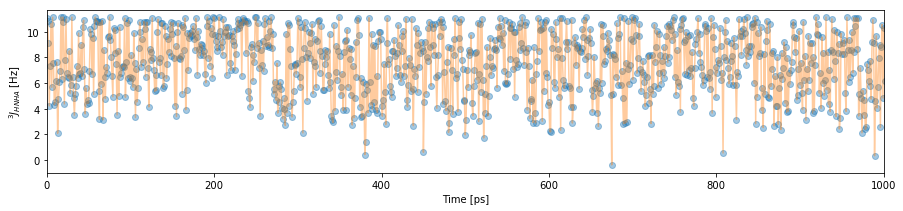

In [292]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(ref_j3_hnha, "o", alpha=0.4)
plt.plot(j3_hnha, "-", alpha=0.4)
plt.xlim(0,1000)
plt.ylabel("$^3J_{HNHA}$ [Hz]")
plt.xlabel("Time [ps]")

Note that diverse J-couplings are calculated for the trajectory.

### Read J-couplings

In [293]:
jkeys = ["3JHNHA","3JHNC","3JHAC","3JCC","3JHNCB","1JNCA","2JNCA","3JHNCA"]

In [294]:
skip = 20 # 20-> 50k
j_ar = np.zeros((28,  1000001))[:,::skip]
j_ar.shape

(28, 50001)

In [295]:
! ls dft2

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
dft2_deg_err_bl5_j.dat	     r4_J1JNCA_dft2_deg_err_bl5
r2_J1JNCA_dft2_deg_err_bl5   r4_J2JNCA_dft2_deg_err_bl5
r2_J2JNCA_dft2_deg_err_bl5   r4_J3JHAC_dft2_deg_err_bl5
r2_J3JCC_dft2_deg_err_bl5    r4_J3JHNCA_dft2_deg_err_bl5
r2_J3JHAC_dft2_deg_err_bl5   r4_J3JHNCB_dft2_deg_err_bl5
r2_J3JHNCA_dft2_deg_err_bl5  r4_J3JHNC_dft2_deg_err_bl5
r2_J3JHNCB_dft2_deg_err_bl5  r4_J3JHNHA_dft2_deg_err_bl5
r2_J3JHNC_dft2_deg_err_bl5   r5_J1JNCA_dft2_deg_err_bl5
r2_J3JHNHA_dft2_deg_err_bl5  r5_J2JNCA_dft2_deg_err_bl5
r3_J1JNCA_dft2_deg_err_bl5   r5_J3JHAC_dft2_deg_err_bl5
r3_J2JNCA_dft2_deg_err_bl5   r5_J3JHNCA_dft2_deg_err_bl5
r3_J3JHAC_dft2_deg_err_bl5   r5_J3JHNCB_dft2_deg_err_bl5
r3_J3JHNCA_dft2_deg_err_bl5  r5_J3JHNC_dft2_deg_err_bl5
r3_J3JHNCB_dft2_deg_err_bl5  r5_J3JHNHA_dft2_deg_err_bl5
r3_J3JHNHA_dft2_deg_err_bl5


In [296]:
J_dft2 = pd.read_table("dft2/dft2_deg_err_bl5_j.dat", 
                  delim_whitespace=True, skipfooter=1, engine='python')

/home/tb/lustelzl/anaconda2/envs/bioen-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [297]:
#tabel_l = [J_dft1, J_dft2, J_orig]
#set_names_l = ["dft1", "dft2", "orig"]

tabel_l = [ J_dft2]
set_names_l = [ "dft2"]

#dft1_fn = "/r{}_J{}_dft1_deg_err_bl5"
dft2_fn = "/r{}_J{}_dft2_deg_err_bl5"
#orig_fn = "/r{}_J{}_orig_deg_err_bl5"

fn_l = [dft2_fn]

raw_l = []
j_path="./"

for set_i, karplus_set in enumerate(set_names_l):
    
    print(karplus_set)
    
    sim_fn = j_path + karplus_set     
    #! ls $sim_fn
    sim_fn += fn_l[set_i]
    
    o = ala5_jcouplings_bioen_input(jkeys, tabel_l[set_i], skip=2,
                                    return_exp_details=True,
                                    err_column_name="sigma",
                                    sim_fn=sim_fn)
    
    raw_l.append(o)

dft2
0 2 3JHNHA
1 3 3JHNHA
2 4 3JHNHA
3 5 3JHNHA
4 2 3JHNC
missing
5 4 3JHNC
6 5 3JHNC
7 2 3JHAC
8 3 3JHAC
9 4 3JHAC
10 5 3JHAC
11 2 3JCC
missing
missing
missing
12 2 3JHNCB
13 3 3JHNCB
14 4 3JHNCB
15 5 3JHNCB
16 2 1JNCA
17 3 1JNCA
18 4 1JNCA
19 5 1JNCA
20 2 2JNCA
21 3 2JNCA
22 4 2JNCA
23 5 2JNCA
24 2 3JHNCA
25 3 3JHNCA
26 4 3JHNCA
27 5 3JHNCA


In [298]:
for set_i, karplus_set in enumerate(set_names_l):
    
    
    res_jcp_l, y_tilde, yTilde, Y_Tilde, exp_obs_err = raw_l[set_i]
    
    N = y_tilde.shape[1]
    w0 = (np.matrix(np.ones(N)/(N))).T
    
    opt_dir = karplus_set+"_for_opt"
    #! mkdir -p $karplus_set
    ! mkdir -p $opt_dir
    #np.savetxt("for_opt/G.txt", G)
    np.savetxt(opt_dir+"/w0.txt", w0)
    np.savetxt(opt_dir+"/y.txt", y_tilde)
    np.savetxt(opt_dir+"/yTilde.txt", yTilde)
    np.savetxt(opt_dir+"/Y_Tilde.txt", Y_Tilde)

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'


In [299]:
! ls dft2

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
dft2_deg_err_bl5_j.dat	     r4_J1JNCA_dft2_deg_err_bl5
r2_J1JNCA_dft2_deg_err_bl5   r4_J2JNCA_dft2_deg_err_bl5
r2_J2JNCA_dft2_deg_err_bl5   r4_J3JHAC_dft2_deg_err_bl5
r2_J3JCC_dft2_deg_err_bl5    r4_J3JHNCA_dft2_deg_err_bl5
r2_J3JHAC_dft2_deg_err_bl5   r4_J3JHNCB_dft2_deg_err_bl5
r2_J3JHNCA_dft2_deg_err_bl5  r4_J3JHNC_dft2_deg_err_bl5
r2_J3JHNCB_dft2_deg_err_bl5  r4_J3JHNHA_dft2_deg_err_bl5
r2_J3JHNC_dft2_deg_err_bl5   r5_J1JNCA_dft2_deg_err_bl5
r2_J3JHNHA_dft2_deg_err_bl5  r5_J2JNCA_dft2_deg_err_bl5
r3_J1JNCA_dft2_deg_err_bl5   r5_J3JHAC_dft2_deg_err_bl5
r3_J2JNCA_dft2_deg_err_bl5   r5_J3JHNCA_dft2_deg_err_bl5
r3_J3JHAC_dft2_deg_err_bl5   r5_J3JHNCB_dft2_deg_err_bl5
r3_J3JHNCA_dft2_deg_err_bl5  r5_J3JHNC_dft2_deg_err_bl5
r3_J3JHNCB_dft2_deg_err_bl5  r5_J3JHNHA_dft2_deg_err_bl5
r3_J3JHNHA_dft2_deg_err_bl5


### Prepare BioEn optimization

#### Function to run series of BioEn optimizations

In [300]:
from collections import defaultdict
from bioen.analyze import utils

In [301]:
def run_theta_series(w0, y, yTilde, Y_Tilde, opt_method="forces", verbose=True,
                     theta_l=[100000, 10000, 1000, 200, 10, 1, 0.2, 0.1, 0],
                     cfg=None):
    wopt_d = {}
    yopt_d = {}
    time_d = {}
    S_d = {}
    chi2_d = {}
    L_d = {}
    
    N = len(w0.flat)
    M = yTilde.shape[0]
        
    #w0 = w0.reshape((N,1))
        
    G = optimize.log_weights.getGs(w0.reshape((N,1)))
    GInit = optimize.log_weights.getGs(w0.reshape((N,1)))
    #G = G.reshape(N)
    #GInit = GInit.reshape(N)
    #print(G.shape)
    
    forces_init = optimize.forces.init_forces(M)
    
    if np.all(cfg) is None:
        # using defaults
        cfg = optimize.minimize.Parameters()
    
    for i, theta in enumerate(theta_l):
        if verbose:
            print(theta)
        
        if opt_method == "log-weights":
            start=time.time()
            
            
            
            o = optimize.log_weights.find_optimum(GInit, G, 
                                            y, yTilde, Y_Tilde, theta, cfg)
            end=time.time()
            dt=end-start
            wopt, yopt, gopt, f_initial, f_final = o 
            
            # calculate S and chi2
            S = utils.get_entropy(w0, wopt)*-1 # to get KL 
            chi2 = optimize.common.chiSqrTerm(wopt, yTilde, Y_Tilde)
            
            
            #Ginit = optimize.log_weights.getGs(wopt)
            GInit = gopt
           
        if opt_method == 'forces':
            start=time.time()

            o = optimize.forces.find_optimum(forces_init, w0,
                                             y, yTilde,
                                             Y_Tilde, theta, cfg)
            end=time.time()
            dt=end-start

            # outputs from minimization
            wopt, yopt, forces_opt, f_initial, f_final, chi2, S = o
            
            # Get forces for next optimization
            forces_init = forces_opt.reshape((M,1))
           
       
        if verbose:
           # Needs fixing here
           if i > 0:
                print("start F {}, final F {}".format(L_d[theta_l[i-1]], f_final))
 
       
        wopt_d[theta] = wopt
        yopt_d[theta] = yopt
        time_d[theta] = dt
        S_d[theta] = S
        chi2_d[theta] = chi2 
        L_d[theta] = f_final
     
    return wopt_d, yopt_d, L_d, chi2_d, S_d

#### Handling output

In [302]:
def overview_table(theta_l, L_d, chi2_d, S_d, out_path="out"):
    data = []
    for i, theta in enumerate(theta_l):
        data.append([theta, S_d[theta], chi2_d[theta], L_d[theta]])
    np.savetxt(out_path+"/opt_data.dat", data, header="theta, S, chiSqr, F, offset") 
    
    
def bioen_save_out_array(ar_theta_dict, output_name="theta{}_dat.txt"):
    for key, value in ar_theta_dict.items():
        np.savetxt(output_name.format(key), value)    
    

In [303]:
from bioen import optimize
import os, sys, time

In [304]:
#! cp ~/bio/BioEn/ala5/ala5_ph2/ala5_ph2_2/nb_dft1/run1/thetas2.dat . 
#! cp /home/tb/lustelzl/DATA/Projects/BioEn/rna-example/lbfgs_2.yaml . 

In [305]:
cfg = optimize.util.load_template_config_yaml(
    "lbfgs_2.yaml", "lbfgs")

#cfg = optimize.minimize.Parameters('gsl')
cfg["verbose"] = True

In [306]:
cfg

{'minimizer': 'lbfgs',
 'debug': True,
 'verbose': True,
 'params': {'linesearch': 2,
  'max_iterations': 20000,
  'delta': 1e-06,
  'epsilon': 1e-05,
  'ftol': 0.0001,
  'gtol': 0.9,
  'past': 10,
  'max_linesearch': 100,
  'wolfe': 0.9},
 'n_threads': -1,
 'cache_ytilde_transposed': 'auto',
 'algorithm': '',
 'use_c_functions': True}

In [307]:
theta_ar = np.genfromtxt("thetas2.dat")

In [308]:
w0.shape


(50001, 1)

In [309]:
optimize.log_weights.getGs(w0.reshape(50001,1))

matrix([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [310]:
 #optimize.log_weights.find_optimum?

In [311]:
recalc = True

output_d = defaultdict(dict)

for method in ['log-weights', 'forces']:
     
    output_d[method] = defaultdict(dict)


for method in [  'forces']:

    for set_i, karplus_set in enumerate(set_names_l):
        print(karplus_set)
        
        out_path = "out/"+method+"/"+karplus_set
        
        if os.path.exists(out_path+"/opt_data.dat") and not recalc:
            print("already calculated")
            
            # need to load previous calculations
            
        else:
            # Start timer
            start_th_series = time.time()
            
            opt_pth=karplus_set+"_for_opt/"
            print(opt_pth)
    
            #initial weights
            w0 = np.genfromtxt(opt_pth+"/w0.txt")
            # copy to output directory
            ! mkdir -p $out_path"/for_opt"
            #! echo $out_path+"for_opt"
            print(out_path+"/for_opt")
            np.savetxt(out_path+"/for_opt/w0.txt", w0)

        
            #N = 50001
            w0= w0.reshape(50001,1)
    
            # Observables for each structure scaled by the inverse of the experimental error
            yTilde  = np.genfromtxt(opt_pth+"/yTilde.txt")
    
            # Experimental observables divided by the experimental uncertainty
            Y_Tilde = np.genfromtxt(opt_pth+"/Y_Tilde.txt")
            Y_Tilde = Y_Tilde.reshape(1, Y_Tilde.shape[0])
    
            # Experimental observables
            y = np.genfromtxt(opt_pth+"/y.txt")
    
            # BioEn optimization
            wopt_d, yopt_d, L_d, chi2_d, S_d = run_theta_series(
                w0, y, yTilde, Y_Tilde,
                theta_l=theta_ar, cfg=cfg, verbose=True,
                opt_method=method)
    
            # End timer
            end_th_series = time.time()
            dt_th_series = end_th_series - start_th_series
        
            # Outputs
            
            # copy inital observables to output dir
            np.savetxt(out_path+"/for_opt/y.txt", y)
            
            output_d[method][karplus_set] = [wopt_d, yopt_d, L_d, chi2_d, S_d, dt_th_series]
        
            ! mkdir -p out/
            ! mkdir -p "out/"$method
        
            ! mkdir -p $out_path
            ! mkdir -p $out_path"/wopt"; mkdir -p $out_path"/yopt"
        
    
            np.savetxt(out_path+"/time.txt", np.vstack((start_th_series,
                                                       end_th_series,
                                                       dt_th_series)))
    
            overview_table(
                theta_ar, L_d, chi2_d, S_d, out_path=out_path) 
            bioen_save_out_array(
                wopt_d, output_name=out_path+"/wopt/w_theta{}_dat.txt")
            bioen_save_out_array(
                yopt_d, output_name=out_path+"/yopt/y_theta{}_dat.txt")

dft2
dft2_for_opt/
/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
out/forces/dft2/for_opt
100000.0
fmin_initial 26.667980199148303
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  0.11296558380126953
fmin_initial           = 26.667980199148303
fmin_final             = 26.6617282051306
83955.78619995104
fmin_initial 26.660724312947707
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  0.1337141990661621
fmin_initial           = 26.660724312947707
fmin_final             = 26.66053321811696
start F 26.6617282051306, final F 26.66053321811696
70485.74036451904
fmin_initial 26.659334022081204
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  0.10654902458190918
fmin_initial           = 26.659334022081204
fmin_final             = 26.65911065646816
start F 26.66053321811

fmin_initial           = 26.336051654651396
fmin_final             = 26.32764628120266
start F 26.38107830471831, final F 26.32764628120266
1503.8869469554102
fmin_initial 26.274457405669782
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  0.13027286529541016
fmin_initial           = 26.274457405669782
fmin_final             = 26.264570611204313
start F 26.32764628120266, final F 26.264570611204313
1262.6001098748552
fmin_initial 26.20181162945409
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  0.11013507843017578
fmin_initial           = 26.20181162945409
fmin_final             = 26.190225716269772
start F 26.264570611204313, final F 26.190225716269772
1060.0258488068823
fmin_initial 26.11631617759401
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  0.10743236541748047
fmin_initial           = 26.11631617759401
fmin_final             = 26.102768115

time elapsed  0.17848539352416992
fmin_initial           = 17.525866215477546
fmin_final             = 17.464549142427444
start F 18.176591811703133, final F 17.464549142427444
22.616759492228645
fmin_initial 16.809766992138123
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  0.18634939193725586
fmin_initial           = 16.809766992138123
fmin_final             = 16.751194189819692
start F 17.464549142427444, final F 16.751194189819692
18.988078244652613
fmin_initial 16.09778763268263
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  0.19797563552856445
fmin_initial           = 16.09778763268263
fmin_final             = 16.042488700112095
start F 16.751194189819692, final F 16.042488700112095
15.94159037455998
fmin_initial 15.395923721449758
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  0.23350906372070312
fmin_initial           = 15.39592372144975

time elapsed  1.4985311031341553
fmin_initial           = 6.643810627476025
fmin_final             = 6.636994353212924
start F 6.791518032657317, final F 6.636994353212924
0.3401304938279253
fmin_initial 6.503883138927846
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  1.0632004737854004
fmin_initial           = 6.503883138927846
fmin_final             = 6.497891707807231
start F 6.636994353212924, final F 6.497891707807231
0.28555923019901064
fmin_initial 6.376102592760756
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  1.0952670574188232
fmin_initial           = 6.376102592760756
fmin_final             = 6.372481439292238
start F 6.497891707807231, final F 6.372481439292238
0.23974349678010784
fmin_initial 6.264725745272014
--------------------------
FORCES -- Library L-BFGS/C
--------------------------
time elapsed  1.6554183959960938
fmin_initial           = 6.264725745272014
fmin_final   

In [312]:
w0.shape, y.shape, yTilde.shape, Y_Tilde.shape

((50001, 1), (28, 50001), (28, 50001), (1, 28))

### Analysis

Focus on results of calculation with generalized forces.

#### Setup

In [313]:
def optimal_theta_entropy_change(theta_l, s_ar, deltaS=0.5, verbose=False):
    """
    Find theta that gives desired entropy change
    """ 
    s_index = np.argmin(np.absolute(s_ar - deltaS))
    theta = theta_l[s_index]
    if verbose:
       print(s_index, theta_l[s_index], s_ar[s_index])
    return theta, s_index


def format_ala5_chi_s_plot(fig, ax, xlabel=r"$\mathregular{\chi^2}$", ylabel=r"$\mathregular{S_{KL}}$",
                      xlim=[-0.1, 3.8]):
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)
    ax.set_xticks([0, 1,2,3])
    ax.set_xticks([0.5, 1.5, 2.5], minor=True)
    fig.tight_layout()
    return fig, ax

In [314]:
! ls out/forces/dft2

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
for_opt  opt_data.dat  time.txt  wopt  yopt


In [315]:
para_set = "dft2"
pth_out = "out/forces/"+para_set

In [316]:
opt_out = np.genfromtxt(pth_out+"/opt_data.dat")

In [317]:
theta_ar = opt_out[:,0]

In [318]:
np.argmin(np.absolute(opt_out[:,1] - 0.5))

55

In [319]:
th_all, th_all_index = optimal_theta_entropy_change(
theta_ar, opt_out[:,1], deltaS=0.5, verbose=True)

55 6.649435996665045 0.5010047595131707


In [320]:
th_all, th_all_index

(6.649435996665045, 55)

In [321]:
opt_out[th_all_index]

array([ 6.649436  ,  0.50100476,  8.80065926, 12.13205834])

In [322]:
w_s05 = np.genfromtxt(pth_out+"/wopt/w_theta{}_dat.txt".format(th_all))

In [323]:
w0 = np.genfromtxt(pth_out+"/for_opt/w0.txt")

#### Elbow plots

In [324]:
#cl = sns.color_palette()

In [325]:
cl = [(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
 (0.33333333333333331, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.30588235294117649, 0.32156862745098042),
 (0.50588235294117645, 0.44705882352941179, 0.69803921568627447),
 (0.80000000000000004, 0.72549019607843135, 0.45490196078431372),
 (0.39215686274509803, 0.70980392156862748, 0.80392156862745101)]

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'


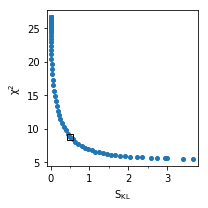

In [326]:
fig, ax = plt.subplots(figsize=(3,3))
#sns.set_style('ticks')
ax.plot(opt_out[:,1], opt_out[:,2], "o", ms=4)
ax.plot(opt_out[:,1][th_all_index], opt_out[:,2][th_all_index], "s", mfc="None",
        mec="black", mew=1,label=r"$\mathregular{\theta}=$"+"{:.2f}".format(
th_all))
fig, ax = format_ala5_chi_s_plot(fig, ax, xlim=[-0.1,3.8])
fig.tight_layout()
! mkdir -p plots/opt_overview
fig.savefig("plots/opt_overview/ala5_L-curve_{}.pdf".format(para_set))

In [327]:
print(opt_out[:,2][th_all_index], opt_out[:,2][th_all_index] / 28)

8.800659258700401 0.31430925923930003


/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'


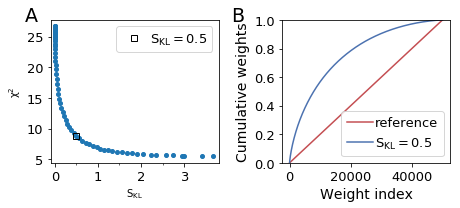

In [328]:
fig, ax = plt.subplots(1,2, figsize=(6.5,3))
#sns.set_style('ticks')
ax[0].plot(opt_out[:,1], opt_out[:,2], "o", ms=4)
ax[0].plot(opt_out[:,1][th_all_index], opt_out[:,2][th_all_index], "s", mfc="None",
mec="black", mew=1,label=r"$\mathregular{S_{KL}=0.5}$")
fig, ax[0] = format_ala5_chi_s_plot(fig, ax[0], xlim=[-0.1,3.8])
ax[1].plot(np.cumsum(np.sort(w0)[::-1]), c=cl[2], label="reference")
ax[1].plot(np.cumsum(np.sort(w_s05)[::-1]), c=cl[0], label=r"$\mathregular{S_{KL}=0.5}$")
ax[1].set_ylim(0,1)
ax[1].set_xlabel("Weight index", fontsize=14)
ax[1].set_ylabel("Cumulative weights", fontsize=14)
ax[0].text(-0.15,0.99, "A", fontsize=19, transform=ax[0].transAxes)
ax[1].text(-0.3,0.99, "B", fontsize=19, transform=ax[1].transAxes)

for ai, a in enumerate(['A', 'B']):
    ax[ai].legend(fontsize=13, handletextpad=0.2)
    #ax[ai].text(-0.3,1.01, a , fontsize=18, transform=ax[ai].transAxes)
    ax[ai].tick_params(axis='both', which='major', labelsize=13)
    fig.tight_layout()

! mkdir -p plots/opt_overview
fig.savefig("plots/opt_overview/ala_chi2_S_{}.pdf".format(para_set))

In [329]:
# save for replotting L-curves
np.savetxt("plots/opt_overview/s_chi2_{:.2f}".format(th_all),
np.column_stack((opt_out[:,1], opt_out[:,2])))

In [330]:
opt_out[th_all_index]

array([ 6.649436  ,  0.50100476,  8.80065926, 12.13205834])

In [331]:
print(th_all)

6.649435996665045


#### Ramachandran plots

In [332]:
import matplotlib.colors as colors

def phi_psi_pmf(phi_psi, nbins=100, return_edges=False, weights=None, missing_counts_g=15):
    c, ex, ey = phi_psi_hist(phi_psi, nbins=nbins, weights=weights)
    lnp = ln_p_hist_counts(c, missing_counts_g=missing_counts_g)
    
    if return_edges:
       return lnp, ex, ey
    else:
         return lnp
        

def ln_p_hist_counts(c, missing_counts_g=15):
    ln_counts = -np.log(c / float(c.sum()))
    ln_counts[np.isinf(ln_counts)] = missing_counts_g
    return ln_counts

def phi_psi_hist(phi_psi, nbins=100, weights=None):
    c, xe, ye = np.histogram2d(phi_psi[:,0], phi_psi[:,1], bins=nbins,
                                range=[[-180,180],[-180,180]],
                                weights=weights)
    return c, xe, ye  


def plot_rama_delta_g(free_energy_2d, fig_ax=None, vmin=-3, vmax=3, label="MD-PDB", cmap='bwr'):
    
    if np.all(fig_ax) is None:
       fig, ax = plt.subplots(figsize=(4.5,4.5))
    else:
         fig, ax = fig_ax
    
    im = ax.imshow(free_energy_2d, origin="low",
                   extent=[-180,180, -180,180], label=label, cmap=cmap,  vmin=vmin, vmax=vmax)

    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, norm=colors.Normalize(vmin=vmin, vmax=vmax))
    
    ax.set_xticks(np.arange(-180, 180+90, step=90));
    ax.set_yticks(np.arange(-180, 180+90, step=90));
    
    ax.set_xlabel("$\mathregular{\phi \; [^{\circ}]}$", fontsize=13)
    ax.set_ylabel("$\mathregular{\psi \; [^{\circ}]}$", fontsize=13)
    
    return fig, ax, cb



##### MD results

In [333]:
! ls c_phi_psi*

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
c_phi_psi_deg_2  c_phi_psi_deg_4  c_phi_psi_deg_6
c_phi_psi_deg_3  c_phi_psi_deg_5


In [334]:
p="."
fn = p+"/c_phi_psi_deg_{}"
step = 2
res_phi_psi_ar_l = [np.genfromtxt(fn.format(i))[::step] for i in range(3,6)]

In [335]:
md_phi_psi = np.vstack(res_phi_psi_ar_l)

In [336]:
md_phi_psi.shape

(150003, 2)

##### Optimal BioEn ensemble 

In [337]:
md_w_all = np.hstack(([w_s05]*3))

In [338]:
nbins = 65
missing_pmf = 16

In [339]:
lnp_all = phi_psi_pmf(md_phi_psi, weights=md_w_all,
                      nbins=nbins, missing_counts_g=missing_pmf)


/home/tb/lustelzl/anaconda2/envs/bioen-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [340]:
lnp_md = phi_psi_pmf(md_phi_psi, nbins=nbins, return_edges=False, missing_counts_g=missing_pmf)

/home/tb/lustelzl/anaconda2/envs/bioen-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


#### PDB statistics

In [341]:
#! cp /home/tb/lustelzl/DATA/Projects/BioEn/5ala/coil-ala/ala_phi_psi.txt .

In [342]:
pdb_phi_psi = np.genfromtxt("ala_phi_psi.txt")

In [343]:
lnp_pdb = phi_psi_pmf(pdb_phi_psi, nbins=nbins, return_edges=False, missing_counts_g=missing_pmf)

/home/tb/lustelzl/anaconda2/envs/bioen-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


#### Plot

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/home/tb/lustelzl/DATA/Projects/BioEn/release-bioen/mpcdf-fio/bioen-fio/bioen-internal/examples/ala5_optimize
/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'


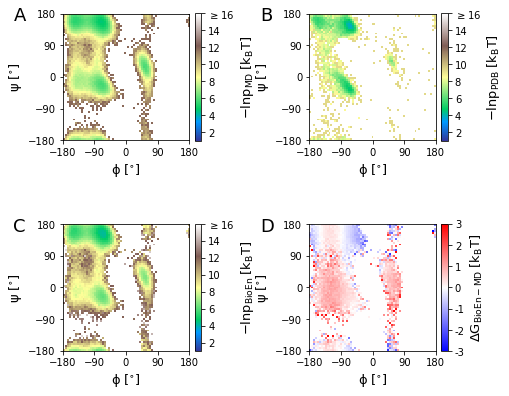

In [344]:
! pwd
! mkdir -p plots
! mkdir -p plots/phi_psi_lnp

fig, ax = plt.subplots(2,2, figsize=(7.,6))

fig, ax[0,0], cb0 = plot_rama_delta_g(lnp_md.T, vmin=1, vmax=16, fig_ax=[fig, ax[0,0]], cmap="terrain")
fig, ax[0,1], cb1 = plot_rama_delta_g(lnp_pdb.T, vmin=1, vmax=16, fig_ax=[fig, ax[0,1]], cmap="terrain")

fig, ax[1,0], cb2 = plot_rama_delta_g(lnp_all.T, vmin=1, vmax=16, fig_ax=[fig, ax[1,0]], cmap='terrain')
fig, ax[1,1], cb3 = plot_rama_delta_g(lnp_all.T - lnp_md.T, vmin=-3, vmax=3, fig_ax=[fig, ax[1,1]])

cb3.set_ticks([-3, -2, -1, 0, 1, 2, 3])
cb3.set_ticklabels(['-3', '-2', '-1', '0', '1', '2', '3'])

for cb in [cb0, cb1, cb2]:
    cb.set_ticks([2,4, 6,8,10,12,14, 16])
    cb.set_ticklabels(['2', '4', '6', '8', '10', '12', '14', '$\mathregular{\geq 16}$'])

cb0.set_label(r"$\mathregular{- \ln p_{MD}   \; \left[k_BT \right]}$",
            fontsize=13)
cb1.set_label(r"$\mathregular{- \ln p_{PDB}   \; \left[k_BT \right]}$",
            fontsize=13)

cb2.set_label(r"$\mathregular{- \ln p_{BioEn}   \; \left[k_BT \right]}$",
            fontsize=13)
cb3.set_label(r"$\mathregular{\Delta G_{BioEn-MD}   \; \left[k_BT \right]}$",
            fontsize=13)


for ai, a in enumerate(['A', 'B', 'C', 'D']):
    ax.flat[ai].text(-320, 160, a, fontsize=18)


fig.tight_layout()
fig.savefig("plots/phi_psi_lnp/{}_lnp_phi_psi_all.pdf".format(para_set))

## Fit to experiment at optimal $\theta$

In [345]:
exp_obs_err

array([[ 5.59,  0.91],
       [ 5.74,  0.91],
       [ 5.98,  0.91],
       [ 6.54,  0.91],
       [ 1.13,  0.59],
       [ 1.15,  0.59],
       [ 1.16,  0.59],
       [ 1.85,  0.38],
       [ 1.86,  0.38],
       [ 1.89,  0.38],
       [ 2.19,  0.38],
       [ 0.19,  0.22],
       [ 2.3 ,  0.39],
       [ 2.24,  0.39],
       [ 2.14,  0.39],
       [ 1.96,  0.39],
       [11.36,  0.59],
       [11.26,  0.59],
       [11.25,  0.59],
       [11.49,  0.59],
       [ 9.2 ,  0.5 ],
       [ 8.55,  0.5 ],
       [ 8.4 ,  0.5 ],
       [ 8.27,  0.5 ],
       [ 0.67,  0.1 ],
       [ 0.68,  0.1 ],
       [ 0.69,  0.1 ],
       [ 0.73,  0.1 ]])

In [346]:
uniq_jkeys  = np.array(['3JHNHA', '3JHNC', '3JHAC', '3JCC', '3JHNCB', '1JNCA', '2JNCA', '3JHNCA'])

In [347]:
jkeys

['3JHNHA', '3JHNC', '3JHAC', '3JCC', '3JHNCB', '1JNCA', '2JNCA', '3JHNCA']

In [348]:
#jkeys_all = np.genfromtxt("dft2/dft2_deg_err_bl5_j.dat", dtype=str, skip_header=1, skip_footer=1,
#                         usecols=[0,1])

In [349]:
res_jcp_l

['r2 3JHNHA',
 'r3 3JHNHA',
 'r4 3JHNHA',
 'r5 3JHNHA',
 'r2 3JHNC',
 'r4 3JHNC',
 'r5 3JHNC',
 'r2 3JHAC',
 'r3 3JHAC',
 'r4 3JHAC',
 'r5 3JHAC',
 'r2 3JCC',
 'r2 3JHNCB',
 'r3 3JHNCB',
 'r4 3JHNCB',
 'r5 3JHNCB',
 'r2 1JNCA',
 'r3 1JNCA',
 'r4 1JNCA',
 'r5 1JNCA',
 'r2 2JNCA',
 'r3 2JNCA',
 'r4 2JNCA',
 'r5 2JNCA',
 'r2 3JHNCA',
 'r3 3JHNCA',
 'r4 3JHNCA',
 'r5 3JHNCA']

In [350]:
#y = np.genfromtxt(pth_out+"/for_opt/y.txt")
y_w0 = np.mean(y, axis=1)





In [351]:
y_th_opt = np.genfromtxt(pth_out+"/yopt/y_theta{}_dat.txt".format(th_all))

In [352]:
y.shape

(28, 50001)

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
['r2', '3JHNHA']
['r3', '3JHNHA']
['r4', '3JHNHA']
['r5', '3JHNHA']
['r2', '3JHNC']
['r4', '3JHNC']
['r5', '3JHNC']
['r2', '3JHAC']
['r3', '3JHAC']
['r4', '3JHAC']
['r5', '3JHAC']
['r2', '3JCC']
['r2', '3JHNCB']
['r3', '3JHNCB']
['r4', '3JHNCB']
['r5', '3JHNCB']
['r2', '1JNCA']
['r3', '1JNCA']
['r4', '1JNCA']
['r5', '1JNCA']
['r2', '2JNCA']
['r3', '2JNCA']
['r4', '2JNCA']
['r5', '2JNCA']
['r2', '3JHNCA']
['r3', '3JHNCA']
['r4', '3JHNCA']
['r5', '3JHNCA']


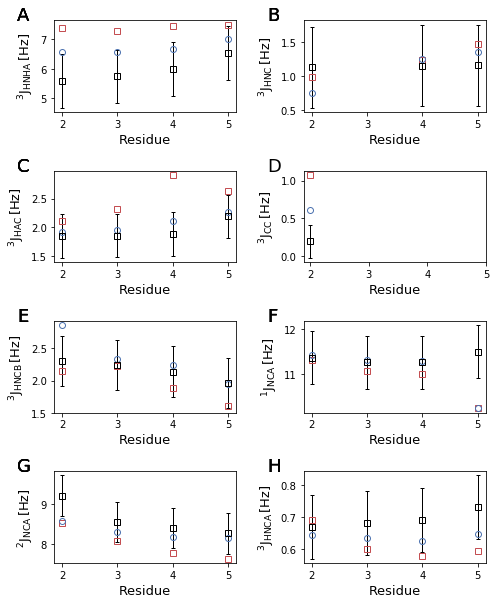

In [354]:
! mkdir -p plots/j_couplings
fig, ax  = plt.subplots(4,2, figsize=(7,8.5)) 
lettters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']



for ri, _row in enumerate(res_jcp_l):
    row = _row.split()
    print(row)

    uniq_id = np.where(uniq_jkeys == row[1])[0][0]

    res = int(row[0][1:])

    #Experiment
    ax.flat[uniq_id].errorbar(res, exp_obs_err[ri,0], yerr=exp_obs_err[ri,1],

                              marker="s", mew=1, mfc="None", c='black', capthick=1,
                              elinewidth=1, capsize=2, 
                              linestyle="None", label='Exp.')

    # MD
    ax.flat[uniq_id].plot(res, y_w0[ri], "s", label="w0", c=cl[2], mfc="None", mew=1.0,
                         mec=cl[2])

    

    #BioEn
    ax.flat[uniq_id].plot(res, y_th_opt[ri], "o",
                         c=cl[0], mfc="None", mew=1.0, mec=cl[0])

    

    super_script = r"$\mathregular{^"+row[1][0]+"J_{"+row[1][2:]+"}\, [Hz]}$"

    ax.flat[uniq_id].set_ylabel(super_script, fontsize=13)
    ax.flat[uniq_id].set_xlabel("Residue", fontsize=13)
    ax.flat[uniq_id].set_xticks([2,3,4,5])
    ax.flat[uniq_id].text(-0.2,1, lettters[uniq_id] , fontsize=18,

                          transform=ax.flat[uniq_id].transAxes)
    
fig.tight_layout()

## Plot fit for each observable

In [355]:
def chi_per_observ_theta(theta_l, y_theta_l, jkeys_all, exp_obs_err_ar):
    """
    Extract chi^2 per observation at each value of theta
    """
    chi_out_l = []
    res_out_l = []
    
    for theta_i, theta in enumerate(theta_l):
        exp_type_chi_dict = defaultdict(list)
        exp_res_chi_dict = defaultdict(list)
    
        y_theta = y_theta_l[theta_i]
    
        for row_number, obs_calc in enumerate(y_theta):
            
            # read identifiers for observations
            res_num = jkeys_all[row_number,0]
            exp_type = jkeys_all[row_number,1]
            
        
            # read exp table to get raw exp value and error
            exp_obs = exp_obs_err_ar[row_number,0]
            exp_err = exp_obs_err_ar[row_number,1]
        
            chi2 = calc_chi2_from_arrays(obs_calc,  exp_err, exp_obs)
            exp_type_chi_dict[exp_type].append(chi2)
            exp_res_chi_dict[exp_type].append(res_num)
        
        chi_out_l.append(exp_type_chi_dict)    
        res_out_l.append(exp_res_chi_dict) 
        
    return chi_out_l, res_out_l


def get_theta_exp_list(theta_l, y_fn):
    y_fn_l = []
    for theta in theta_l:
        y = np.genfromtxt(y_fn.format(theta))
        y_fn_l.append(y)
    return y_fn_l


def calc_chi2_from_arrays(exp_ar, error_ar, sim_ar):
    """
    Eq. 4 in Hummer&Koefinger, JCP, 2016 + BUT with missing factor 2 included
    
    Parameters:
    -----------
    exp_ar: array
            Experimental observables
    error_ar: array
              Sigma, comibined simulation and experimental error
    sim_ar: array
            Observables calculated from model
    
    Returns:
    --------
    chi2_ar: array
             Chi2
    
    """
    return np.sum((exp_ar - sim_ar)**2 / (2.*error_ar**2))

In [357]:
y_all_fn = pth_out+"/yopt/y_theta{}_dat.txt"

In [358]:
theta_l = theta_ar.tolist()

In [359]:
y_theta_l = get_theta_exp_list(theta_l, y_all_fn)

In [360]:
j_keys_all = np.array([row.split() for row in res_jcp_l])

In [362]:
j_keys_all

array([['r2', '3JHNHA'],
       ['r3', '3JHNHA'],
       ['r4', '3JHNHA'],
       ['r5', '3JHNHA'],
       ['r2', '3JHNC'],
       ['r4', '3JHNC'],
       ['r5', '3JHNC'],
       ['r2', '3JHAC'],
       ['r3', '3JHAC'],
       ['r4', '3JHAC'],
       ['r5', '3JHAC'],
       ['r2', '3JCC'],
       ['r2', '3JHNCB'],
       ['r3', '3JHNCB'],
       ['r4', '3JHNCB'],
       ['r5', '3JHNCB'],
       ['r2', '1JNCA'],
       ['r3', '1JNCA'],
       ['r4', '1JNCA'],
       ['r5', '1JNCA'],
       ['r2', '2JNCA'],
       ['r3', '2JNCA'],
       ['r4', '2JNCA'],
       ['r5', '2JNCA'],
       ['r2', '3JHNCA'],
       ['r3', '3JHNCA'],
       ['r4', '3JHNCA'],
       ['r5', '3JHNCA']], dtype='<U6')

In [363]:
chi_obsv_all, reslab_all = chi_per_observ_theta(theta_l,
                                                y_theta_l, j_keys_all, exp_obs_err)

In [365]:
uniq_jkeys

array(['3JHNHA', '3JHNC', '3JHAC', '3JCC', '3JHNCB', '1JNCA', '2JNCA',
       '3JHNCA'], dtype='<U6')

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'


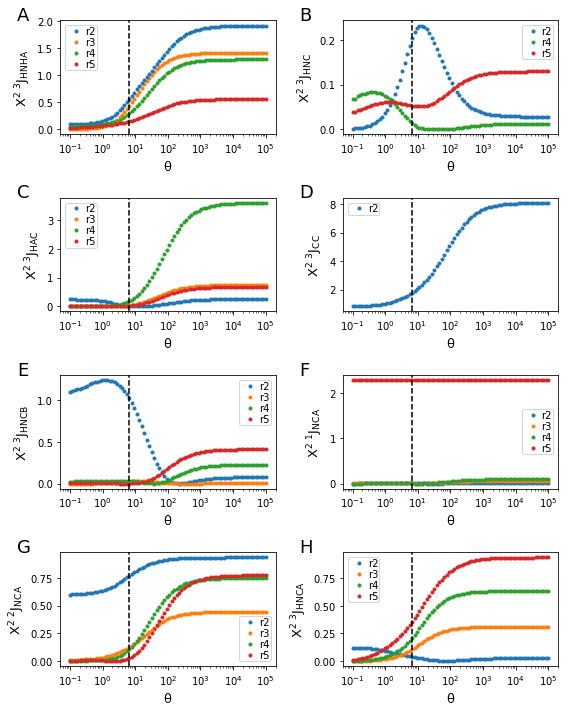

In [366]:
fig, ax  = plt.subplots(4,2, figsize=(8,10)) 


letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
#chi2_theta_l = []

for i_exp, exp_type in enumerate(uniq_jkeys):
    
    ylabel1 = "{}".format(exp_type[0])
    ylabel2 = "{}".format(exp_type[2:])
    chi2_str = r"$\mathregular{X^{2} \;}$"
    ax.flat[i_exp].set_ylabel(chi2_str +r"$\mathregular{^"+ylabel1+"J_{"+ylabel2+"}}$",
                           fontsize=13)    
    
    for ti, o in enumerate(chi_obsv_all):
        
        resid_ti = reslab_all[ti]
        _resid = resid_ti[exp_type]
        
        #print ti, exp_type
        dev_l = []
        _chi2 = o[exp_type]
    
        dev_l.append(_chi2)
        for ci, c in enumerate(_chi2):
            
            color_index = int(_resid[ci][1:]) -2
            
            if  ti==0:
                ax.flat[i_exp].plot(
                    theta_l[ti],  c, ".", c="C{}".format(color_index),
                    label="{}".format(_resid[ci]))
                ax.flat[i_exp].legend()
                
            else:
                 ax.flat[i_exp].plot(
                    theta_l[ti], c, c="C{}".format(color_index), marker=".")

    #ax.flat[i_exp].plot(theta_l[ti], np.sum(dev_l, axis=1), ".", c="grey")              
    ax.flat[i_exp].semilogx()       
    ax.flat[i_exp].set_xlabel(r"$\mathregular{\theta}$", fontsize=13)
    ax.flat[i_exp].legend(handletextpad=-0.1, borderpad=0.1, labelspacing=0.1)
    
    
    ax.flat[i_exp].axvline(th_all, linestyle="--", c="k")
    
    ax.flat[i_exp].text(-0.2,1., letters[i_exp] , fontsize=18,
                        transform=ax.flat[i_exp].transAxes)
    
    
    
fig.tight_layout()
! mkdir -p plots//plot_chi2
fig.savefig("plots/plot_chi2/{}_all_chi2.png".format(para_set))
fig.savefig("plots/plot_chi2/{}_all_chi2.pdf".format(para_set))

In [367]:
np.hstack(chi_obsv_all[th_all_index].values()).sum() 

/home/tb/lustelzl/anaconda2/envs/bioen-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


8.800659258700403

In [368]:
opt_out[55]

array([ 6.649436  ,  0.50100476,  8.80065926, 12.13205834])